In [1]:
import os
import shutil
import math
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, EfficientNetV2B0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
base_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset"

In [4]:
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

In [5]:
# Hitung jumlah gambar dalam setiap kelas
data_distribution = {}
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    total_images = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg', '.JPG'))])
    data_distribution[class_name] = total_images

# Tampilkan hasil
for class_name, count in data_distribution.items():
    print(f"{class_name}: {count} images")

def count_total_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len(files)  # Jumlah file di setiap subfolder
    return total_images

total_images = count_total_images(base_dir)
print(f"\nTotal jumlah citra di dataset: {total_images}")

AMERICAN GOLDFINCH: 143 images
BARN OWL: 129 images
CARMINE BEE-EATER: 131 images
DOWNY WOODPECKER: 137 images
EMPEROR PENGUIN: 139 images
FLAMINGO: 132 images

Total jumlah citra di dataset: 811


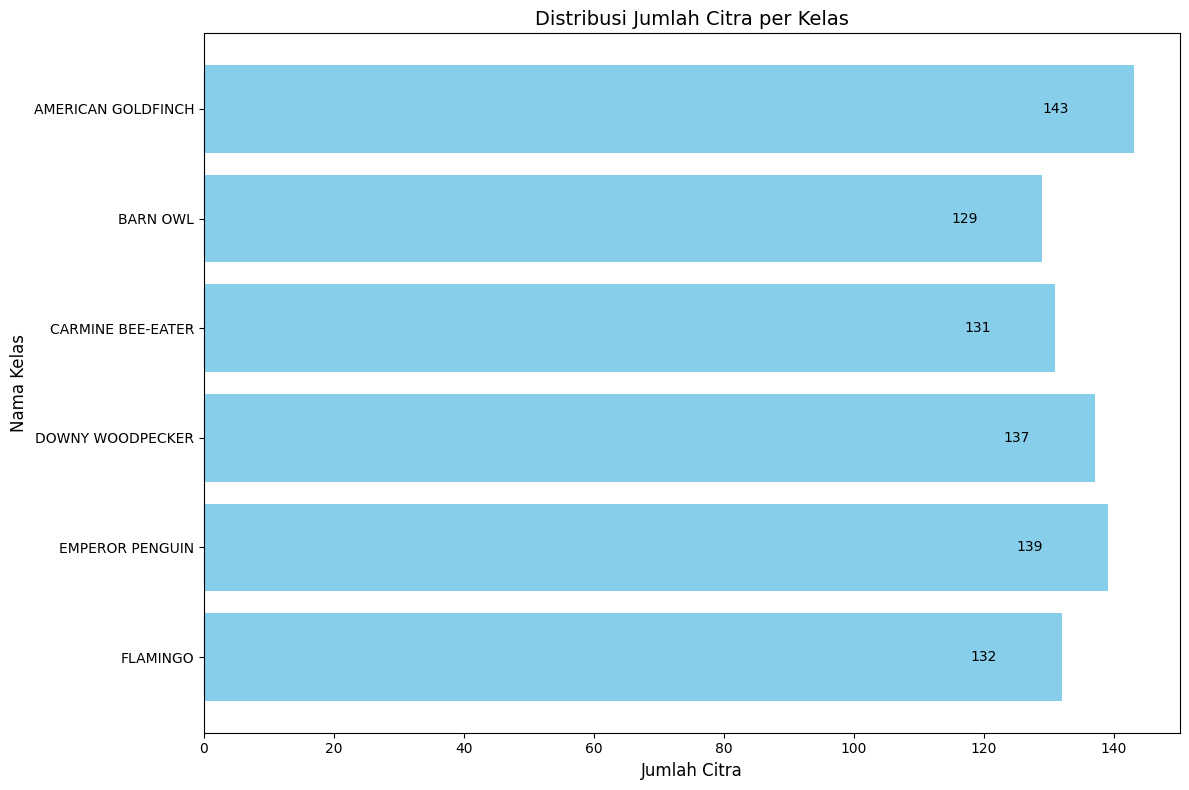

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
class_names_list = list(data_distribution.keys())
image_counts = list(data_distribution.values())

bars = ax.barh(class_names_list, image_counts, color='skyblue')

for bar in bars:
    ax.text(bar.get_width() - 10, bar.get_y() + bar.get_height()/2,
            str(int(bar.get_width())), va='center', ha='right', fontsize=10, color='black')

ax.set_title("Distribusi Jumlah Citra per Kelas", fontsize=14)
ax.set_xlabel("Jumlah Citra", fontsize=12)
ax.set_ylabel("Nama Kelas", fontsize=12)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

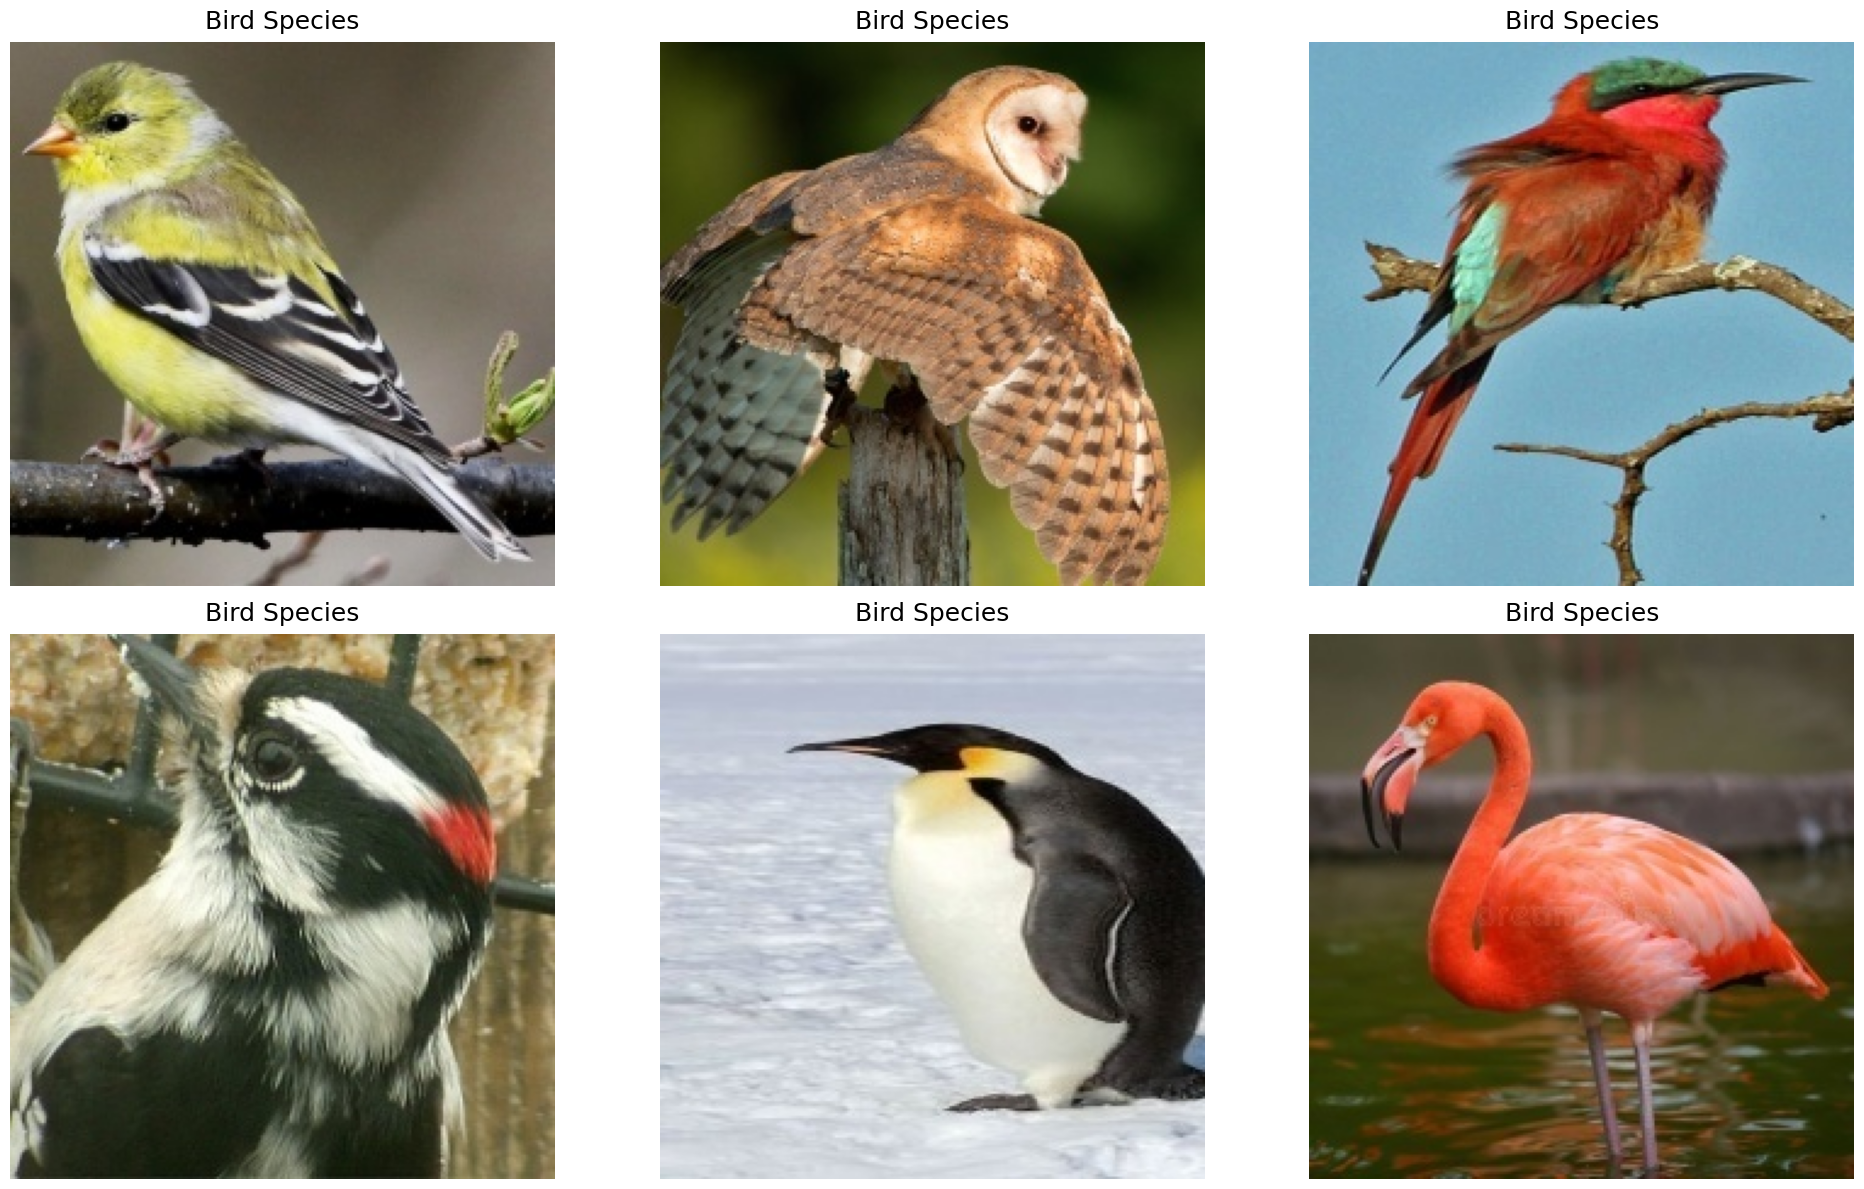

In [7]:
images = []

for leaf_dir in class_names:
    leaf_items = os.listdir(os.path.join(base_dir, leaf_dir))

    if leaf_items:
      selected_images = np.random.choice(leaf_items)
      images.append(os.path.join(base_dir, leaf_dir, selected_images))

# Visualization
fig = plt.figure(1, figsize=(20, 12))
for subplot, image_ in enumerate(images):
    category = image_.split("/")[-2]
    imgs = plt.imread(image_)
    fig = plt.subplot(2, 3, subplot + 1)
    fig.set_title(category, pad=10, size=18)
    plt.imshow(imgs)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Splitting Data

In [28]:
base_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset"
split_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT"

train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'validation')
test_dir = os.path.join(split_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

train_split = 0.7
val_split = 0.15
test_split = 0.15

for class_name in class_names:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    train_count = int(len(images) * train_split)
    val_count = int(len(images) * val_split)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for subset, img_list in zip(['train', 'validation', 'test'],
                                [train_images, val_images, test_images]):
        target_dir = os.path.join(split_dir, subset, class_name)
        os.makedirs(target_dir, exist_ok=True)

        for img_name in img_list:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(target_dir, img_name)
            shutil.copy2(src, dst)

print("Split data selesai.")

Split data selesai.


In [8]:
split_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT"
train_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT/train"
val_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT/validation"
test_dir = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-SPLIT/test"

# Augmentasi Data (Data Train)

In [9]:
output_dir  = "C:/Users/HP/Documents/MACHINE LEARNING/Bird Species/Bird Species Dataset-AUGMENTED"

In [10]:
target_per_class = 1000
IMG_EXTS = ('.jpg', '.jpeg', '.png')

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def is_img(fn):
    return fn.lower().endswith(IMG_EXTS)

def copy_originals(src_root, dst_root):
    os.makedirs(dst_root, exist_ok=True)
    for class_name in sorted(os.listdir(src_root)):
        src_cls = os.path.join(src_root, class_name)
        if not os.path.isdir(src_cls):
            continue
        dst_cls = os.path.join(dst_root, class_name)
        os.makedirs(dst_cls, exist_ok=True)
        for f in os.listdir(src_cls):
            if is_img(f):
                src_f = os.path.join(src_cls, f)
                dst_f = os.path.join(dst_cls, f)
                if not os.path.exists(dst_f):
                    shutil.copy2(src_f, dst_f)

def count_images(dir_path):
    if not os.path.isdir(dir_path):
        return 0
    return sum(is_img(f) for f in os.listdir(dir_path))

def augment_to_target(input_path, output_path, target_per_class):
    os.makedirs(output_path, exist_ok=True)

    for class_name in sorted(os.listdir(input_path)):
        class_input_dir = os.path.join(input_path, class_name)
        if not os.path.isdir(class_input_dir):
            continue
        class_output_dir = os.path.join(output_path, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        existing = count_images(class_output_dir)
        if existing >= target_per_class:
            print(f"[SKIP] '{class_name}': sudah {existing} >= target {target_per_class}")
            continue

        print(f"[AUG ] {class_name}: {existing} -> {target_per_class} (generate {target_per_class - existing})")

        gen = datagen.flow_from_directory(
            directory=os.path.join(input_path, class_name, '..'),
            classes=[class_name],
            target_size=(224, 224),
            batch_size=1,
            class_mode=None,
            shuffle=True,
            save_to_dir=class_output_dir,
            save_prefix='aug',
            save_format='jpg',
            seed=42
)

        while existing < target_per_class:
            _ = next(gen)
            existing += 1

print("Menyalin gambar asli (train) ke output...")
copy_originals(train_dir, output_dir)

print("Menambahkan hasil augmentasi sampai target per kelas...")
augment_to_target(train_dir, output_dir, target_per_class)

print("\nProses augmentasi selesai.")

Menyalin gambar asli (train) ke output...
Menambahkan hasil augmentasi sampai target per kelas...
[AUG ] AMERICAN GOLDFINCH: 100 -> 1000 (generate 900)
Found 100 images belonging to 1 classes.
[AUG ] BARN OWL: 90 -> 1000 (generate 910)
Found 90 images belonging to 1 classes.
[AUG ] CARMINE BEE-EATER: 91 -> 1000 (generate 909)
Found 91 images belonging to 1 classes.
[AUG ] DOWNY WOODPECKER: 95 -> 1000 (generate 905)
Found 95 images belonging to 1 classes.
[AUG ] EMPEROR PENGUIN: 97 -> 1000 (generate 903)
Found 97 images belonging to 1 classes.
[AUG ] FLAMINGO: 92 -> 1000 (generate 908)
Found 92 images belonging to 1 classes.

Proses augmentasi selesai.


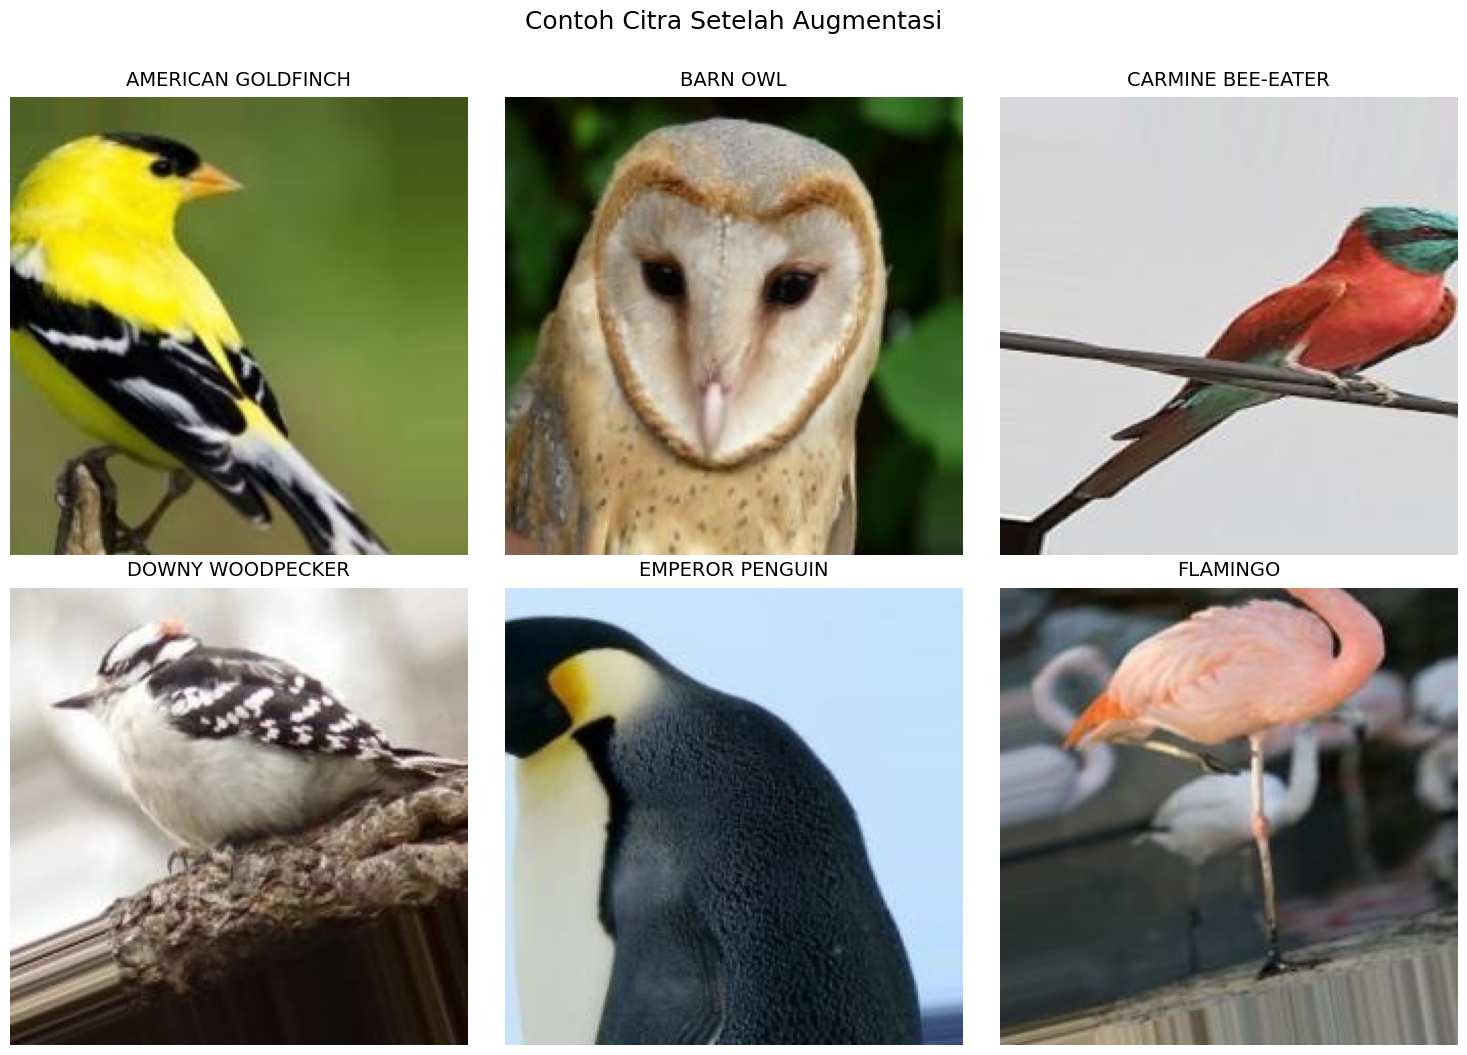

In [11]:
class_names = sorted([d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))])
images = []

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    leaf_items = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if leaf_items:
        selected_image = np.random.choice(leaf_items)
        images.append(os.path.join(class_dir, selected_image))

fig = plt.figure(figsize=(15, 10))
for i, image_path in enumerate(images):
    category = os.path.basename(os.path.dirname(image_path))
    img = plt.imread(image_path)
    plt.subplot(2, 3, i + 1)
    plt.title(category, fontsize=14, pad=8)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Contoh Citra Setelah Augmentasi", fontsize=18, y=1.05)
plt.show()

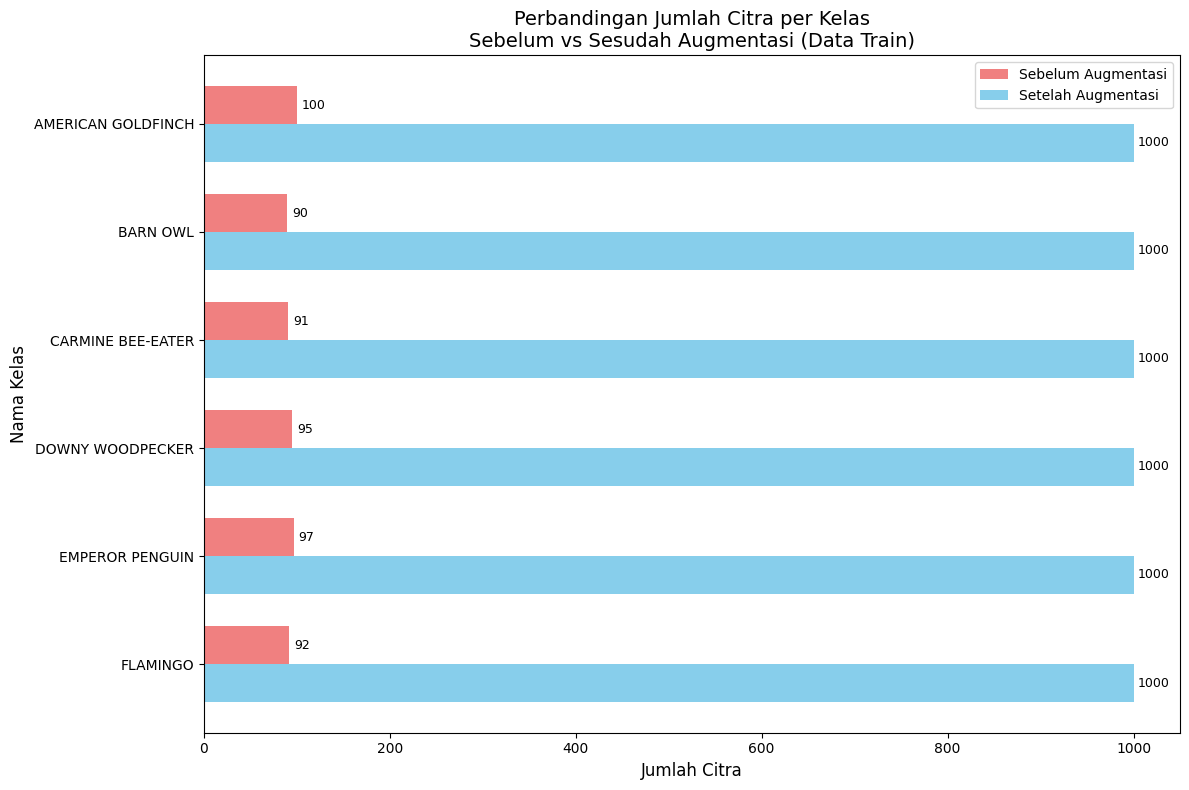

In [12]:
train_distribution = {}
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        train_distribution[class_name] = count

aug_distribution = {}
for class_name in sorted(os.listdir(output_dir)):
    class_path = os.path.join(output_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        aug_distribution[class_name] = count

class_names = sorted(train_distribution.keys())
train_counts = [train_distribution[c] for c in class_names]
aug_counts = [aug_distribution.get(c, 0) for c in class_names]

y = np.arange(len(class_names))
height = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y - height/2, train_counts, height, label='Sebelum Augmentasi', color='lightcoral')
ax.barh(y + height/2, aug_counts, height, label='Setelah Augmentasi', color='skyblue')

ax.set_xlabel("Jumlah Citra", fontsize=12)
ax.set_ylabel("Nama Kelas", fontsize=12)
ax.set_title("Perbandingan Jumlah Citra per Kelas\nSebelum vs Sesudah Augmentasi (Data Train)", fontsize=14)
ax.set_yticks(y)
ax.set_yticklabels(class_names)
ax.legend()
ax.invert_yaxis()

for i, (before, after) in enumerate(zip(train_counts, aug_counts)):
    ax.text(before + 5, i - height/2, str(before), va='center', fontsize=9, color='black')
    ax.text(after + 5, i + height/2, str(after), va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [13]:
image_size = (224, 224)
batch_size = 32

train_dir = output_dir

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6000 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.


# MobileNetV2

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)



9406464/9406464 [==============================] - 11s 1us/step


In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan layer MobileNet (opsional, bisa fine-tuning nanti)
for layer in base_model.layers:
    layer.trainable = False

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
188/188 [==============================] - 67s 357ms/step - loss: 1.0455 - accuracy: 0.6413 - val_loss: 0.6193 - val_accuracy: 0.9322
Epoch 2/15
188/188 [==============================] - 64s 341ms/step - loss: 0.7335 - accuracy: 0.8042 - val_loss: 0.3987 - val_accuracy: 0.9661
Epoch 3/15
188/188 [==============================] - 65s 343ms/step - loss: 0.5201 - accuracy: 0.8803 - val_loss: 0.2718 - val_accuracy: 0.9661
Epoch 4/15
188/188 [==============================] - 64s 342ms/step - loss: 0.3907 - accuracy: 0.9143 - val_loss: 0.1983 - val_accuracy: 0.9746
Epoch 5/15
188/188 [==============================] - 65s 346ms/step - loss: 0.3092 - accuracy: 0.9367 - val_loss: 0.1525 - val_accuracy: 0.9746
Epoch 6/15
188/188 [==============================] - 65s 345ms/step - loss: 0.2467 - accuracy: 0.9543 - val_loss: 0.1237 - val_accuracy: 0.9746
Epoch 7/15
188/188 [==============================] - 65s 345ms/step - loss: 0.1988 - accuracy: 0.9600 - val_loss: 0.1034 - val_ac

In [20]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(f"\nAkurasi model pada data test: {test_acc:.2f}")

4/4 - 2s - loss: 0.0220 - accuracy: 0.9922 - 2s/epoch - 532ms/step

Akurasi model pada data test: 0.99


In [21]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

4/4 [==============================] - 2s 350ms/step
Classification Report:
                    precision    recall  f1-score   support

AMERICAN GOLDFINCH       1.00      0.95      0.98        22
          BARN OWL       1.00      1.00      1.00        20
 CARMINE BEE-EATER       0.95      1.00      0.98        21
  DOWNY WOODPECKER       1.00      1.00      1.00        22
   EMPEROR PENGUIN       1.00      1.00      1.00        22
          FLAMINGO       1.00      1.00      1.00        21

          accuracy                           0.99       128
         macro avg       0.99      0.99      0.99       128
      weighted avg       0.99      0.99      0.99       128



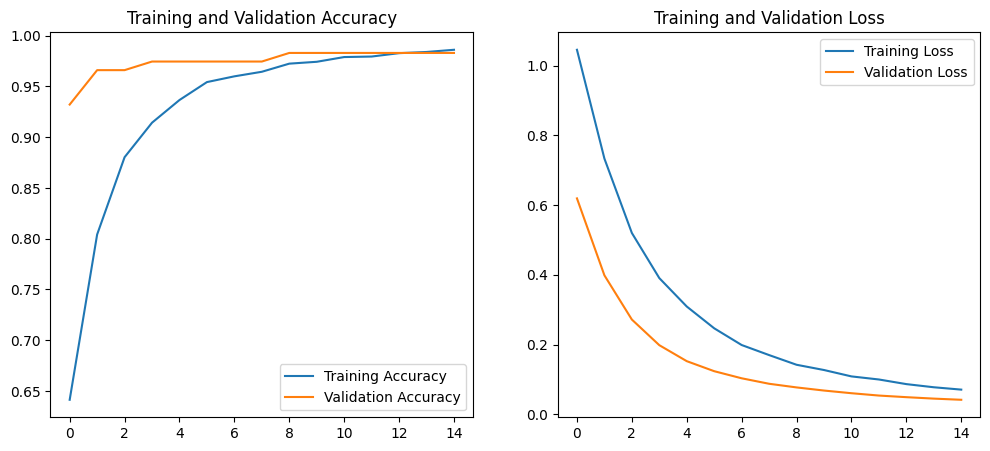

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

4/4 - 2s - 2s/epoch - 378ms/step


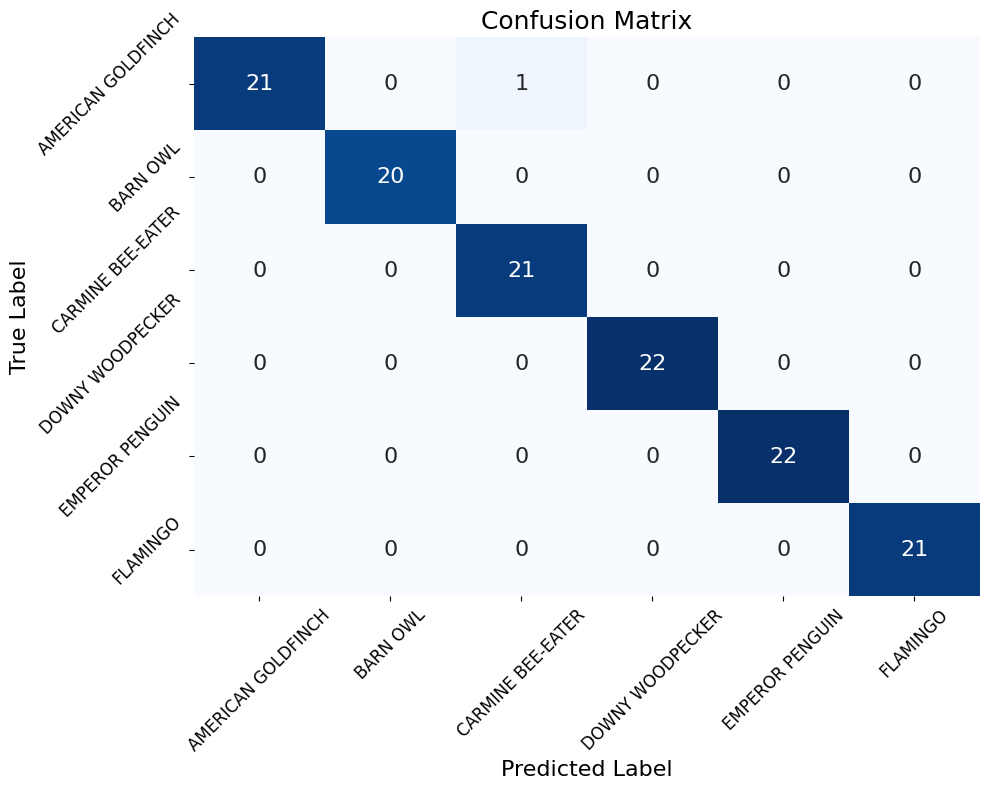

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_pred = model.predict(test_data, verbose=2)
test_pred_class = np.argmax(test_pred, axis=1)
test_true_class = test_data.classes
cm = confusion_matrix(test_true_class, test_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(), cbar=False, annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
model.save("MobileNet.h5")

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
